#### Importing Libraries and Downloading required NLTK components

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import string

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pooja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pooja\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pooja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### For Movie Reviews Dataset

#### Reading the Dataset

In [2]:
trpath = r"reviews_polarity_train.csv"
tpath = r"reviews_polarity_test.csv"

train = pd.read_csv(trpath)
test = pd.read_csv(tpath)

#### Preprocessing Dataset

In [3]:
def wordtag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

def cleantxt(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    fin = [lemmatizer.lemmatize(token, wordtag(tag)) for token, tag in tagged]
    return fin

def preprocess(df):
    df['Text'] = df['Text'].fillna('')
    texts = df['Text'].tolist()
    labels = df['Label'].tolist()
    tokentexts = [cleantxt(text) for text in texts]
    vocab = set(word for tokens in tokentexts for word in tokens)
    return tokentexts, labels, list(vocab)

#### Feature Matrix (Unigram)

In [4]:
def fmatrix(tokendata, vocab):
    vid = {word: i for i, word in enumerate(vocab)}
    matrix = np.zeros((len(tokendata), len(vocab)))
    for i, tokens in enumerate(tokendata):
        for token in tokens:
            if token in vid:
                matrix[i, vid[token]] += 1
    return matrix

#### Naive Bayes Classifier with Out Of Vocabulary Word Handling

In [5]:
class NBClassifier:
    def __init__(self, vsize):
        self.vsize = vsize
        self.cpriors = {}
        self.likelihoods = {}
        self.oov = 1e-3

    def fit(self, X, y):
        classes = set(y)
        ccounts = {cls: 0 for cls in classes}
        wcounts = {cls: np.zeros(self.vsize) for cls in classes}
        for i in range(len(y)):
            ccounts[y[i]] += 1
            wcounts[y[i]] += X[i]
        totdocs = len(y)
        for cls in classes:
            self.cpriors[cls] = np.log2(ccounts[cls] / totdocs)
        for cls in classes:
            totwords = np.sum(wcounts[cls])
            self.likelihoods[cls] = np.log2((wcounts[cls]) / (totwords))
            
    def predict(self, X):
        pred = []
        for doc in X:
            cscores = {}
            for cls in self.cpriors:
                cscores[cls] = self.cpriors[cls] 
                for i, freq in enumerate(doc):
                    if freq > 0:
                        if i < len(self.likelihoods[cls]):
                            wlikelihood = self.likelihoods[cls][i]
                            cscores[cls] += freq * wlikelihood
                        else:
                            wlikelihood = np.log2(self.oov)
                            cscores[cls] += freq * wlikelihood
            pred.append(max(cscores, key=cscores.get))
        return pred

#### Confusion Matrix

In [6]:
def cm(ytrue, ypred, classes):
    matrix = np.zeros((len(classes), len(classes)), dtype=int)
    cid = {cls: idx for idx, cls in enumerate(classes)}
    for true, pred in zip(ytrue, ypred):
        matrix[cid[true]][cid[pred]] += 1
    return matrix

def displaycm(matrix, classes):
    print("Confusion Matrix:")
    print(f"{'Actual by Predicted':<20}", end="")
    for cls in classes:
        print(f"{cls:<10}", end="")
    print()
    for i, row in enumerate(matrix):
        print(f"{classes[i]:<20}", end="")
        for value in row:
            print(f"{value:<10}", end="")
        print()

#### Performance Metrics

In [7]:
def calmetrics(matrix, classes):
    total = np.sum(matrix)
    correct = np.trace(matrix)
    accuracy = correct / total
    precision, recall, f1 = [], [], []
    for i, cls in enumerate(classes):
        tp = matrix[i, i]
        fp = np.sum(matrix[:, i]) - tp
        fn = np.sum(matrix[i, :]) - tp
        p = tp / (tp + fp) if tp + fp > 0 else 0
        r = tp / (tp + fn) if tp + fn > 0 else 0
        f = (2 * p * r) / (p + r) if p + r > 0 else 0
        precision.append(p)
        recall.append(r)
        f1.append(f)
    mprecision = np.mean(precision)
    mrecall = np.mean(recall)
    mf1 = np.mean(f1)

    return accuracy, mprecision, mrecall, mf1

#### Running the Algorithm

In [8]:
trtokens, trlabels, vocab = preprocess(train)
ttokens, tlabels, _ = preprocess(test)

Xtrain = fmatrix(trtokens, vocab)
Xtest = fmatrix(ttokens, vocab)

nb = NBClassifier(vsize=len(vocab))
nb.fit(Xtrain, trlabels)
pred = nb.predict(Xtest)

uclasses = sorted(set(trlabels))
cmatrix = cm(tlabels, pred, uclasses)
ncmatrix = cm(tlabels, pred, uclasses)
displaycm(cmatrix, uclasses)

accuracy, mprecision, mrecall, mf1 = calmetrics(cmatrix, uclasses)
nmetrics = calmetrics(cmatrix, uclasses)
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {mprecision:.4f}")
print(f"Macro Recall: {mrecall:.4f}")
print(f"Macro F1-Score: {mf1:.4f}")

C:\Users\pooja\AppData\Local\Temp\ipykernel_22888\1274897268.py:20: RuntimeWarning: divide by zero encountered in log2
  self.likelihoods[cls] = np.log2((wcounts[cls]) / (totwords))


Confusion Matrix:
Actual by Predicted neg       pos       
neg                 125       25        
pos                 66        84        
Accuracy: 0.6967
Macro Precision: 0.7125
Macro Recall: 0.6967
Macro F1-Score: 0.6909


#### Naive Bayes Classifier with Laplace

In [9]:
class NBClassifierLp:
    def __init__(self, vsize):
        self.vsize = vsize
        self.cpriors = {}
        self.likelihoods = {}

    def fit(self, X, y):
        classes = set(y)
        ccounts = {cls: 0 for cls in classes}
        wcounts = {cls: np.zeros(self.vsize) for cls in classes}

        for i in range(len(y)):
            ccounts[y[i]] += 1
            wcounts[y[i]] += X[i]

        totdocs = len(y)
        for cls in classes:
            self.cpriors[cls] = np.log2(ccounts[cls] / totdocs)
        for cls in classes:
            totwords = np.sum(wcounts[cls])
            self.likelihoods[cls] = np.log2((wcounts[cls] + 1) / (np.sum(wcounts[cls]) + self.vsize))
            
    def predict(self, X):
        pred = []
        for doc in X:
            cscores = {}
            for cls in self.cpriors:
                cscores[cls] = self.cpriors[cls] + np.sum(doc * self.likelihoods[cls])
            pred.append(max(cscores, key=cscores.get))
        return pred

#### Running the Algorithm with Laplace

In [10]:
trtokens, trlabels, vocab = preprocess(train)
ttokens, tlabels, _ = preprocess(test)

Xtrain = fmatrix(trtokens, vocab)
Xtest = fmatrix(ttokens, vocab)

nb = NBClassifierLp(vsize=len(vocab))
nb.fit(Xtrain, trlabels)
pred = nb.predict(Xtest)

uclasses = sorted(set(trlabels))
cmatrix = cm(tlabels, pred, uclasses)
lcmatrix = cm(tlabels, pred, uclasses)
displaycm(cmatrix, uclasses)

accuracy, mprecision, mrecall, mf1 = calmetrics(cmatrix, uclasses)
lmetrics = calmetrics(cmatrix, uclasses)
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {mprecision:.4f}")
print(f"Macro Recall: {mrecall:.4f}")
print(f"Macro F1-Score: {mf1:.4f}")

Confusion Matrix:
Actual by Predicted neg       pos       
neg                 126       24        
pos                 25        125       
Accuracy: 0.8367
Macro Precision: 0.8367
Macro Recall: 0.8367
Macro F1-Score: 0.8367


#### Comparision between Normal Naive Bayes and Laplace Naive Bayes

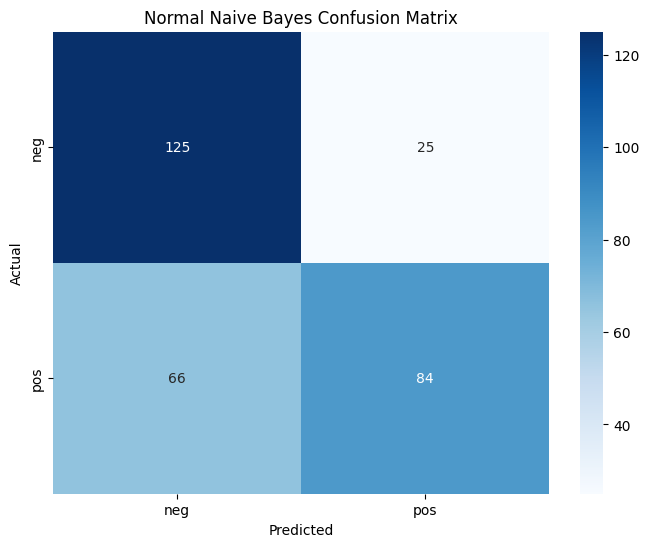

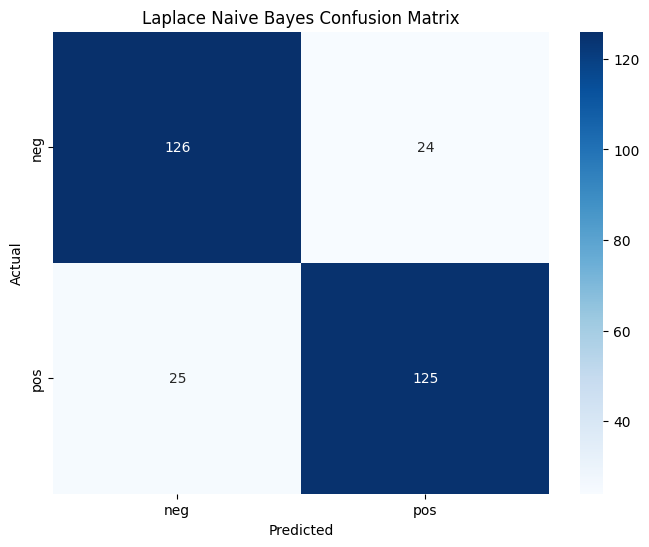

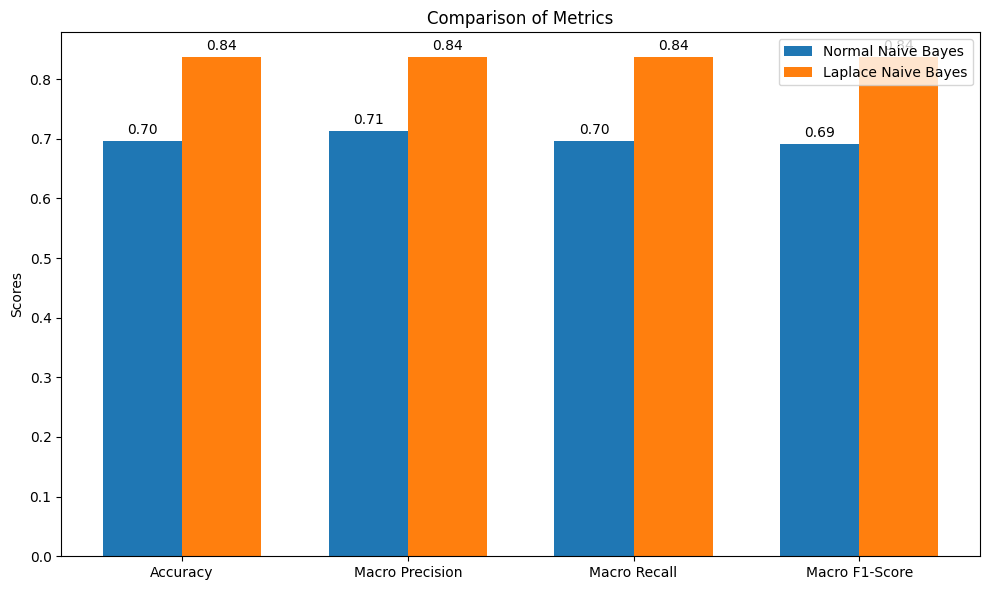

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plotcm(matrix, classes, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'{title} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plotcm(ncmatrix, uclasses, 'Normal Naive Bayes')
plotcm(lcmatrix, uclasses, 'Laplace Naive Bayes')

def plotmetrics(nmetrics, lmetrics):
    metrics = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1-Score']
    nvalues = nmetrics
    lvalues = lmetrics
    x = np.arange(len(metrics))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, nvalues, width, label='Normal Naive Bayes')
    bars2 = ax.bar(x + width/2, lvalues, width, label='Laplace Naive Bayes')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

plotmetrics(nmetrics, lmetrics)

### For News Groups Dataset

#### Reading the Dataset

In [12]:
trpath = r"newsgroup_train.csv"
tpath = r"newsgroup_test.csv"

train = pd.read_csv(trpath)
test = pd.read_csv(tpath)

#### Running the Algorithm

In [13]:
trtokens, trlabels, vocab = preprocess(train)
ttokens, tlabels, _ = preprocess(test)

Xtrain = fmatrix(trtokens, vocab)
Xtest = fmatrix(ttokens, vocab)

nb = NBClassifier(vsize=len(vocab))
nb.fit(Xtrain, trlabels)
pred = nb.predict(Xtest)

uclasses = sorted(set(trlabels))
cmatrix = cm(tlabels, pred, uclasses)
ncmatrix = cm(tlabels, pred, uclasses)
displaycm(cmatrix, uclasses)

accuracy, mprecision, mrecall, mf1 = calmetrics(cmatrix, uclasses)
nmetrics = calmetrics(cmatrix, uclasses)

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {mprecision:.4f}")
print(f"Macro Recall: {mrecall:.4f}")
print(f"Macro F1-Score: {mf1:.4f}")

C:\Users\pooja\AppData\Local\Temp\ipykernel_22888\1274897268.py:20: RuntimeWarning: divide by zero encountered in log2
  self.likelihoods[cls] = np.log2((wcounts[cls]) / (totwords))


Confusion Matrix:
Actual by Predicted atheism   christian misc      
atheism             124       14        4         
christian           142       33        3         
misc                86        14        9         
Accuracy: 0.3869
Macro Precision: 0.4853
Macro Recall: 0.3804
Macro F1-Score: 0.3074


#### Running the Algorithm with Laplace

In [14]:
trtokens, trlabels, vocab = preprocess(train)
ttokens, tlabels, _ = preprocess(test)

Xtrain = fmatrix(trtokens, vocab)
Xtest = fmatrix(ttokens, vocab)

nb = NBClassifierLp(vsize=len(vocab))
nb.fit(Xtrain, trlabels)
pred = nb.predict(Xtest)

uclasses = sorted(set(trlabels))
cmatrix = cm(tlabels, pred, uclasses)
lcmatrix = cm(tlabels, pred, uclasses)
displaycm(cmatrix, uclasses)

accuracy, mprecision, mrecall, mf1 = calmetrics(cmatrix, uclasses)
lmetrics = calmetrics(cmatrix, uclasses)

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {mprecision:.4f}")
print(f"Macro Recall: {mrecall:.4f}")
print(f"Macro F1-Score: {mf1:.4f}")

Confusion Matrix:
Actual by Predicted atheism   christian misc      
atheism             80        58        4         
christian           7         168       3         
misc                18        64        27        
Accuracy: 0.6410
Macro Precision: 0.7118
Macro Recall: 0.5850
Macro F1-Score: 0.5811


#### Comparing Normal Naive Bayes and Laplace Naive Bayes Algorithms

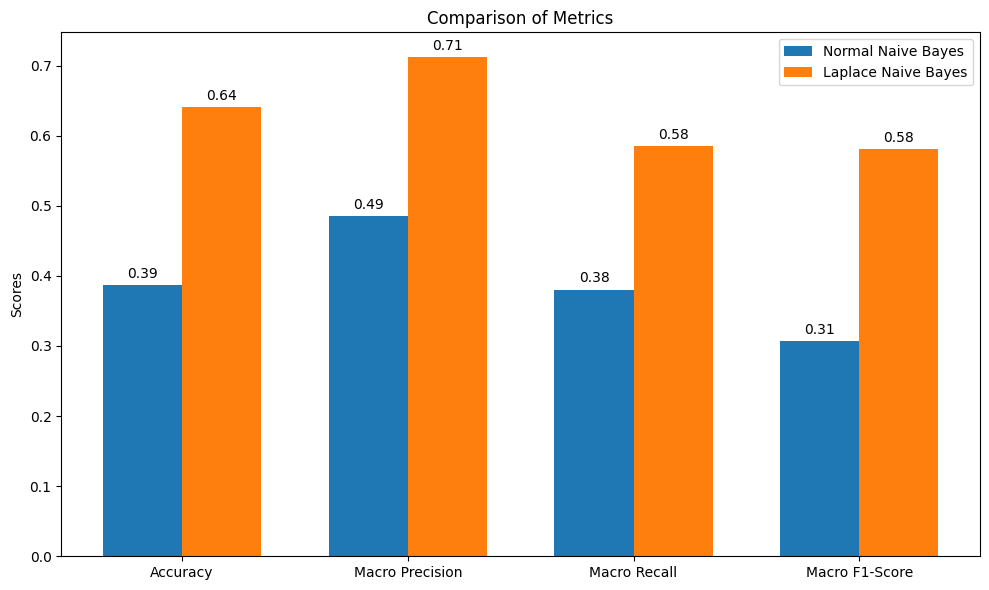

In [15]:
plotmetrics(nmetrics, lmetrics)

### Distribution of labels in the dataset

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def visdata(trtoken, trlabels, vocab, train):
    plt.figure(figsize=(10, 5))
    lcounts = train['Label'].value_counts()
    sns.barplot(x=lcounts.index, y=lcounts.values, palette='viridis')
    plt.title('Label Distribution in Training Data')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    plt.figure(figsize=(10, 5))
    wcounts = [len(entry) for entry in trtoken]
    sns.histplot(wcounts, bins=30, kde=True)
    plt.title('Word Count Distribution in Training Data')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()
    sampdata = train[['Text', 'Label']].sample(5, random_state=42)
    print("\nSample Text Data with Corresponding Labels:")
    print(sampdata)

#### Movie Review Dataset

C:\Users\pooja\AppData\Local\Temp\ipykernel_22888\3077074161.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lcounts.index, y=lcounts.values, palette='viridis')


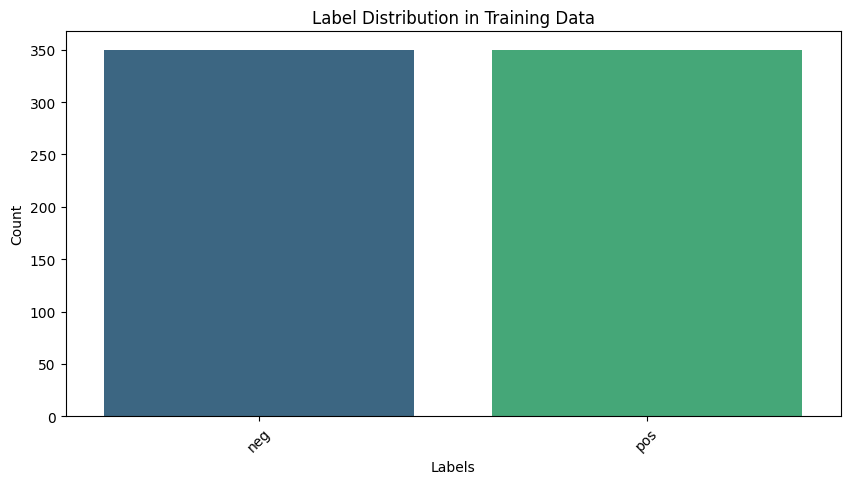

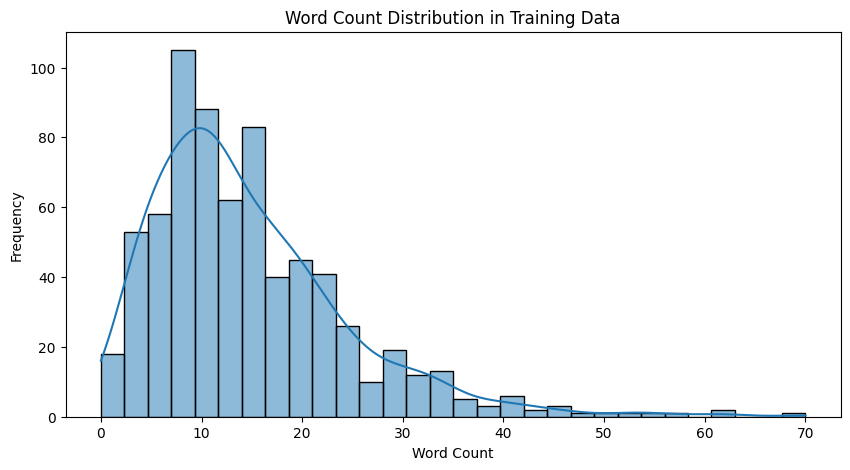


Sample Text Data with Corresponding Labels:
                                                  Text Label
158  i have seen many movies starring jaclyn smith,...   pos
500          and the accents are absolutely abysmal!     neg
396  the performances are real and gripping, the cr...   pos
155  i'm not sure what he was trying to do with thi...   neg
321  it's too bad that everyone else involved didn'...   neg


In [17]:
trpath = r"reviews_polarity_train.csv"
tpath = r"reviews_polarity_test.csv"

train = pd.read_csv(trpath)
test = pd.read_csv(tpath)

trtokens, trlabels, vocab = preprocess(train)
ttokens, tlabels, _ = preprocess(test)

visdata(trtokens, trlabels, vocab, train)

#### News Groups Dataset

C:\Users\pooja\AppData\Local\Temp\ipykernel_22888\3077074161.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lcounts.index, y=lcounts.values, palette='viridis')


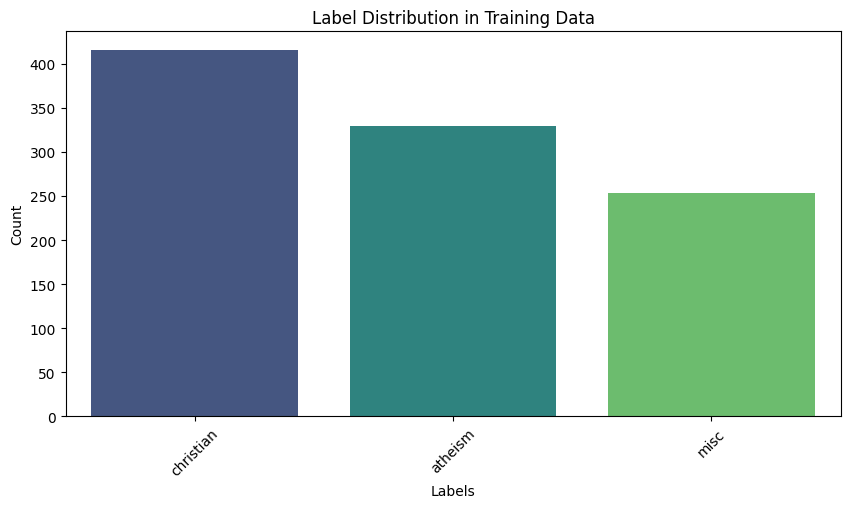

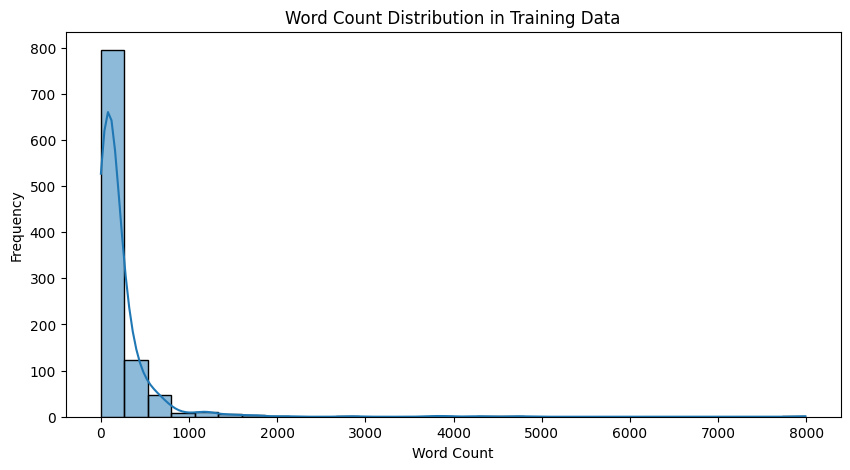


Sample Text Data with Corresponding Labels:
                                                  Text      Label
521  archivename atheismlogicaltatheismarchivename ...    atheism
737  as i was created in the image of gaea therefor...    atheism
740  no it didnt  the motto has been on various coi...    atheism
660  i have been following this thread on talkrelig...  christian
411  which objective system are you talking about  ...    atheism


In [18]:
trpath = r"newsgroup_train.csv"
tpath = r"newsgroup_test.csv"

train = pd.read_csv(trpath)
test = pd.read_csv(tpath)

train = pd.read_csv(trpath)
test = pd.read_csv(tpath)

trtokens, trlabels, vocab = preprocess(train)
ttokens, tlabels, _ = preprocess(test)

visdata(trtokens, trlabels, vocab, train)

#### Word Ninja Library Preprocessing

#### This code is extra (After Downloading the Wordninja library we can run this)

In [19]:
import wordninja

def wordtag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

def segment(text):
    segmented_text = []
    for word in text.split():
        segmented_text.extend(wordninja.split(word))
    return ' '.join(segmented_text)

def cleantxt(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    text = segment(text)
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    fin = [lemmatizer.lemmatize(token, wordtag(tag)) for token, tag in tagged]
    return fin

def preprocess(df):
    df['Text'] = df['Text'].fillna('')
    texts = df['Text'].tolist()
    labels = df['Label'].tolist()
    tokentexts = [cleantxt(text) for text in texts]
    vocab = set(word for tokens in tokentexts for word in tokens)
    return tokentexts, labels, list(vocab)

#### Normal Naive Bayes Algorithm

In [20]:
trtokens, trlabels, vocab = preprocess(train)
ttokens, tlabels, _ = preprocess(test)

Xtrain = fmatrix(trtokens, vocab)
Xtest = fmatrix(ttokens, vocab)

nb = NBClassifier(vsize=len(vocab))
nb.fit(Xtrain, trlabels)
pred = nb.predict(Xtest)

uclasses = sorted(set(trlabels))
cmatrix = cm(tlabels, pred, uclasses)
ncmatrix = cm(tlabels, pred, uclasses)
displaycm(cmatrix, uclasses)

accuracy, mprecision, mrecall, mf1 = calmetrics(cmatrix, uclasses)
nmetrics = calmetrics(cmatrix, uclasses)

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {mprecision:.4f}")
print(f"Macro Recall: {mrecall:.4f}")
print(f"Macro F1-Score: {mf1:.4f}")

C:\Users\pooja\AppData\Local\Temp\ipykernel_22888\1274897268.py:20: RuntimeWarning: divide by zero encountered in log2
  self.likelihoods[cls] = np.log2((wcounts[cls]) / (totwords))


Confusion Matrix:
Actual by Predicted atheism   christian misc      
atheism             122       14        6         
christian           136       37        5         
misc                81        15        13        
Accuracy: 0.4009
Macro Precision: 0.4874
Macro Recall: 0.3954
Macro F1-Score: 0.3353


#### Naive Bayes with Laplace Smoothing

In [21]:
trtokens, trlabels, vocab = preprocess(train)
ttokens, tlabels, _ = preprocess(test)

Xtrain = fmatrix(trtokens, vocab)
Xtest = fmatrix(ttokens, vocab)

nb = NBClassifierLp(vsize=len(vocab))
nb.fit(Xtrain, trlabels)
pred = nb.predict(Xtest)

uclasses = sorted(set(trlabels))
cmatrix = cm(tlabels, pred, uclasses)
lcmatrix = cm(tlabels, pred, uclasses)
displaycm(cmatrix, uclasses)

accuracy, mprecision, mrecall, mf1 = calmetrics(cmatrix, uclasses)
lmetrics = calmetrics(cmatrix, uclasses)

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {mprecision:.4f}")
print(f"Macro Recall: {mrecall:.4f}")
print(f"Macro F1-Score: {mf1:.4f}")

Confusion Matrix:
Actual by Predicted atheism   christian misc      
atheism             109       24        9         
christian           16        152       10        
misc                25        39        45        
Accuracy: 0.7133
Macro Precision: 0.7123
Macro Recall: 0.6781
Macro F1-Score: 0.6801


#### Comparision between two algorithms

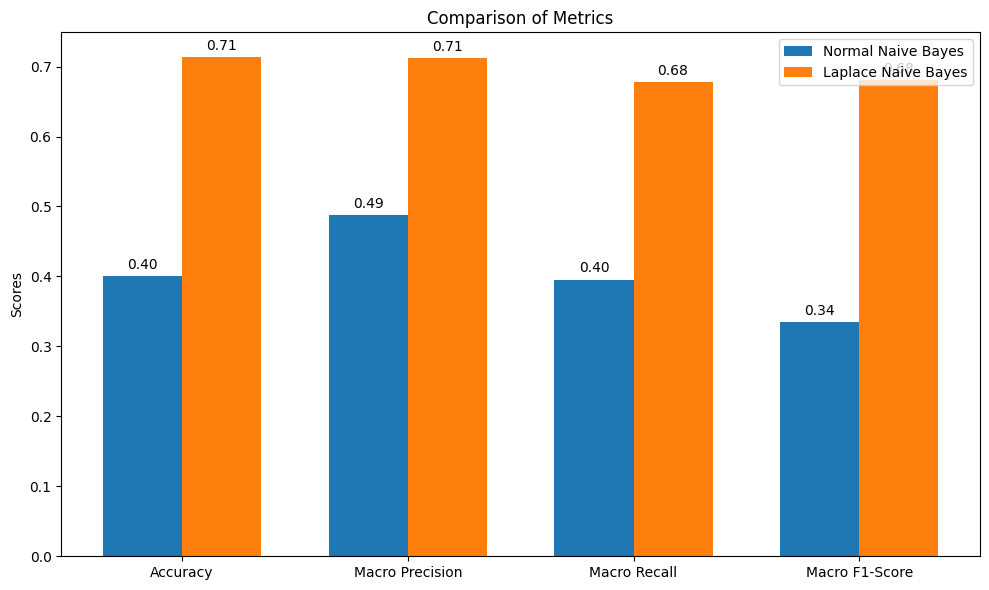

In [22]:
plotmetrics(nmetrics, lmetrics)